# Credit Risk Modeling Project

## 1. Problem Definition
- **Goal:** Predict the probability of loan default (`loan_status`).
- **Why it matters:**  
  - Minimize bank losses.  
  - Ensure compliance with financial regulations.  
  - Make fair, data-driven lending decisions.  

In [ ]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")

Check Shape


In [3]:
df.shape

(32581, 12)

---

## 2. Dataset
- **Borrower features:** age, income, home ownership, employment length.  
- **Loan features:** intent, grade, amount, interest rate, loan/income %.  
- **Credit bureau features:** default history, credit history length.  
- **Target:** `loan_status` (0 = repaid, 1 = default).  

---

In [4]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [8]:
# Check default rate for missing vs non-missing in emp_length
print("Employment Length missing vs non-missing")
print(df.groupby(df['person_emp_length'].isna())['loan_status'].mean())

# Check default rate for missing vs non-missing in loan_int_rate
print("\nInterest Rate missing vs non-missing")
print(df.groupby(df['loan_int_rate'].isna())['loan_status'].mean())


Employment Length missing vs non-missing
person_emp_length
False    0.215426
True     0.315084
Name: loan_status, dtype: float64

Interest Rate missing vs non-missing
loan_int_rate
False    0.219379
True     0.206675
Name: loan_status, dtype: float64


## 3. Data Cleaning
- **Missing values:**  
  - `person_emp_length`: missing borrowers had higher default → create `emp_length_missing` flag + impute median.  
  - `loan_int_rate`: missing similar to others → impute median.  
- Always check default rate in missing groups — missingness can itself be informative.  

---

In [9]:
medians = {}
medians['person_emp_length'] = df['person_emp_length'].median()
medians['loan_int_rate'] = df['loan_int_rate'].median()
print(medians)

{'person_emp_length': 4.0, 'loan_int_rate': 10.99}


In [10]:
# 1. For Employment Length
df['emp_length_missing'] = df['person_emp_length'].isna().astype(int)
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

# 2. For Loan Interest Rate
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

/tmp/ipykernel_36/2857961393.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
/tmp/ipykernel_36/2857961393.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [11]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,emp_length_missing
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0


In [12]:
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
emp_length_missing            0
dtype: int64

In [13]:
df['loan_status'].value_counts(normalize=True)


loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

## 4. Class Balance
- 78% non-default vs 22% default → imbalanced.  
- **Accuracy is misleading** → use **AUC, precision, recall, F1-score**.  
- Used **stratified split** to preserve the default ratio in train/val/test sets.  

---

In [14]:
df.groupby('person_home_ownership')['loan_status'].mean().sort_values(ascending=False)


person_home_ownership
RENT        0.315700
OTHER       0.308411
MORTGAGE    0.125707
OWN         0.074690
Name: loan_status, dtype: float64

In [15]:
df.groupby('loan_status')['person_income'].median()


loan_status
0    60000.0
1    41498.0
Name: person_income, dtype: float64

## 5. EDA Insights
- **Home ownership:**  
  - Renters ≈ 31% default, Owners ≈ 7% → stability reduces risk.  
- **Income:**  
  - Defaulters median ≈ \$41k vs non-defaulters ≈ \$60k → lower income = higher risk.  
- **Other signals:**  
  - Higher loan_percent_income and lower loan grades strongly correlate with default.  

---

<Axes: xlabel='loan_status', ylabel='person_income'>

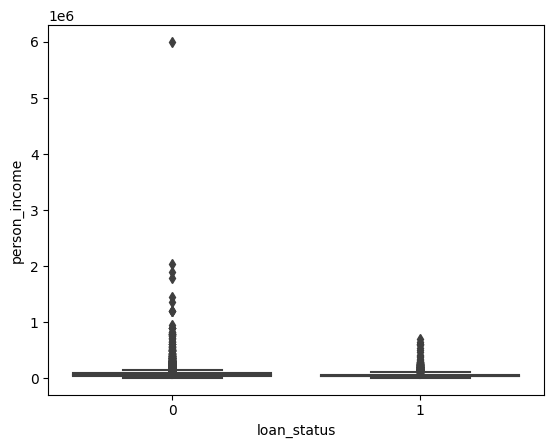

In [16]:
import seaborn as sns
sns.boxplot(x='loan_status', y='person_income', data=df)

## 6. Feature Engineering
- **Encoding:**  
  - One-hot → `person_home_ownership`, `loan_intent`.  
  - Ordinal → `loan_grade` (A–G).  
  - Binary → `cb_person_default_on_file` (Y/N).  
- **Scaling:** Standardize numeric features (age, income, loan amounts) for Logistic Regression.  
- (Tree-based models don’t require scaling.)  

In [17]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# --- copy & prep ---
X = df.copy()


# 2) Binary map for Y/N
X['cb_person_default_on_file'] = X['cb_person_default_on_file'].map({'Y':1, 'N':0}).astype(int)

# 3) Separate target
y = X['loan_status'].astype(int)
X = X.drop(columns=['loan_status'])

# 4) Define feature groups
num_features = [
    'person_age','person_income','person_emp_length','loan_amnt','loan_int_rate',
    'loan_percent_income','cb_person_cred_hist_length','emp_length_missing','cb_person_default_on_file'
]
cat_onehot = ['person_home_ownership','loan_intent']
ord_features = ['loan_grade']
ord_categories = [['A','B','C','D','E','F','G']]  # natural order

# 5) ColumnTransformer: impute numerics (safety), one-hot for nominals, ordinal for grade
preprocess = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_onehot),
        ('ord', OrdinalEncoder(categories=ord_categories, handle_unknown='use_encoded_value', unknown_value=-1), ord_features),
    ],
    remainder='drop'
)

# 6) Fit on training data
preprocess.fit(X)

# 7) Transform for training (optional, to train your model)
X_mat = preprocess.transform(X)

oh_names = preprocess.named_transformers_['onehot'].get_feature_names_out(cat_onehot)
feature_names = np.concatenate([num_features, oh_names, ['loan_grade_ord']])

X_enc = pd.DataFrame(X_mat, columns=feature_names, index=X.index)

print("Encoded shape:", X_enc.shape)
X_enc.head()


Encoded shape: (32581, 20)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,emp_length_missing,cb_person_default_on_file,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_ord
0,22.0,59000.0,123.0,35000.0,16.02,0.59,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
1,21.0,9600.0,5.0,1000.0,11.14,0.10,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,25.0,9600.0,1.0,5500.0,12.87,0.57,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,23.0,65500.0,4.0,35000.0,15.23,0.53,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
4,24.0,54400.0,8.0,35000.0,14.27,0.55,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0


In [18]:
df.shape

(32581, 13)

In [19]:
y

0        1
1        0
2        1
3        1
4        1
        ..
32576    0
32577    0
32578    1
32579    0
32580    0
Name: loan_status, Length: 32581, dtype: int64

In [32]:
print(sorted((X_enc.columns.tolist())))


['cb_person_cred_hist_length', 'cb_person_default_on_file', 'emp_length_missing', 'loan_amnt', 'loan_grade_ord', 'loan_int_rate', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_percent_income', 'person_age', 'person_emp_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_income']


In [21]:
from sklearn.model_selection import train_test_split

# First split: train+valid vs test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train vs valid
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print("Train:", X_train.shape, "Valid:", X_val.shape, "Test:", X_test.shape)
print("Class balance in train:", np.mean(y_train))
print("Class balance in val:", np.mean(y_val))
print("Class balance in test:", np.mean(y_test))


Train: (19548, 20) Valid: (6516, 20) Test: (6517, 20)
Class balance in train: 0.21818088807039082
Class balance in val: 0.21807857581338244
Class balance in test: 0.21819855761853613


**LOGISTIC Regression**

Logistic regression needs features to be on the same scale (especially numeric ones).

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report

# scale numeric features only
num_features = ['person_age', 'person_income', 'person_emp_length', 
                'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                'cb_person_cred_hist_length']

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features]   = scaler.transform(X_val[num_features])
X_test[num_features]  = scaler.transform(X_test[num_features])


We’ll allow class_weight="balanced" so it handles the class imbalance automatically.

In [23]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", solver='lbfgs')
log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

We’ll use AUC as the main metric, but also check precision/recall.

In [24]:
y_val_pred_prob = log_reg.predict_proba(X_val)[:,1]
y_val_pred = log_reg.predict(X_val)

print("Validation AUC:", roc_auc_score(y_val, y_val_pred_prob))
print(classification_report(y_val, y_val_pred))


Validation AUC: 0.8613889926719562
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      5095
           1       0.51      0.78      0.61      1421

    accuracy                           0.79      6516
   macro avg       0.72      0.78      0.73      6516
weighted avg       0.84      0.79      0.80      6516



📊 Metrics you got

Validation AUC = 0.86

This means the model is very good at ranking risky vs. safe borrowers.

In plain terms: if you randomly pick one defaulter and one non-defaulter, the model has an 86% chance of ranking the defaulter higher risk.

In credit risk, anything above 0.75–0.80 is considered strong.

🔎 Confusion matrix results (from precision/recall):

Class 0 (non-default):

Precision: 0.93 → When the model predicts "no default," it's correct 93% of the time.

Recall: 0.79 → It catches about 79% of the actual non-defaulters.

Class 1 (default):

Precision: 0.51 → When the model predicts "default," it’s only correct about half the time.

Recall: 0.78 → But it does catch most of the defaulters (78%).

🎯 Overall accuracy = 79%

Sounds good, but accuracy isn’t the best metric here because the dataset is imbalanced (~22% default).

That’s why AUC and recall are more informative.

💡 Interpretation for credit risk:

The model is conservative in predicting default: it misses some but catches a lot of them (78% recall).

However, it also false-alarms quite a bit: half the predicted defaults are actually safe borrowers (precision = 0.51).

This tradeoff is actually common in banking: models are often tuned to catch more bad borrowers (higher recall) at the cost of some false positives, because approving a defaulter is riskier than rejecting a safe borrower.

So your model is:

Strong overall (AUC 0.86).

Biased toward catching defaulters (good recall).

Needs work to improve precision on defaulters.

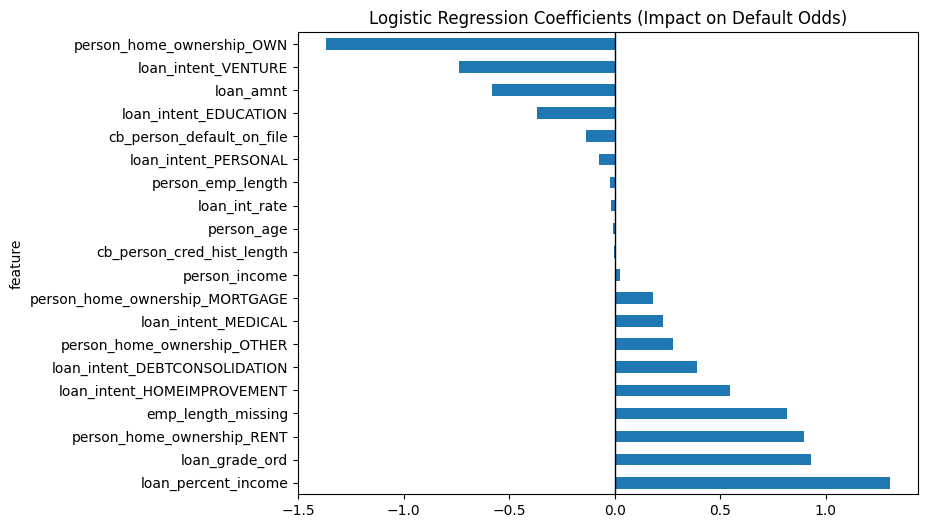

,feature,coefficient
5,loan_percent_income,1.305090
19,loan_grade_ord,0.929018
12,person_home_ownership_RENT,0.897737
7,emp_length_missing,0.817244
15,loan_intent_HOMEIMPROVEMENT,0.547035
13,loan_intent_DEBTCONSOLIDATION,0.389880
10,person_home_ownership_OTHER,0.274621
16,loan_intent_MEDICAL,0.231556
9,person_home_ownership_MORTGAGE,0.181346
1,person_income,0.023782


In [25]:
# ## Step 5: Interpret Logistic Regression Coefficients

import matplotlib.pyplot as plt

# Sort coefficients by magnitude
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": log_reg.coef_[0]
}).sort_values(by="coefficient", ascending=False)

# Plot
plt.figure(figsize=(8,6))
coef_df.set_index("feature")["coefficient"].plot(kind="barh")
plt.title("Logistic Regression Coefficients (Impact on Default Odds)")
plt.axvline(0, color="black", linewidth=1)
plt.show()

coef_df


**RANDOM FOREST**

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Train
rf = RandomForestClassifier(
    n_estimators=300,   # number of trees
    max_depth=10,       # prevent overfitting
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"  # handle class imbalance
)
rf.fit(X_train, y_train)

# Validate
rf_probs = rf.predict_proba(X_val)[:,1]
rf_preds = rf.predict(X_val)

rf_auc = roc_auc_score(y_val, rf_probs)
print("Random Forest Validation AUC:", rf_auc)
print(classification_report(y_val, rf_preds))


Random Forest Validation AUC: 0.9273708061953081
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5095
           1       0.88      0.74      0.80      1421

    accuracy                           0.92      6516
   macro avg       0.90      0.85      0.87      6516
weighted avg       0.92      0.92      0.92      6516



🔎 Random Forest

AUC = 0.927 → Strong discrimination ability.

Class 1 (defaults): Recall = 0.74 → It catches ~74% of defaults.

Precision = 0.88 → Of the loans flagged as risky, 88% are truly defaults.

F1 = 0.80 → Good balance between catching defaults and avoiding false alarms.

In [27]:
from xgboost import XGBClassifier

# Train
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)  # handle imbalance
)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="auc", verbose=50)

# Validate
xgb_probs = xgb.predict_proba(X_val)[:,1]
xgb_preds = xgb.predict(X_val)

xgb_auc = roc_auc_score(y_val, xgb_probs)
print("XGBoost Validation AUC:", xgb_auc)
print(classification_report(y_val, xgb_preds))


[0]	validation_0-auc:0.89533


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-auc:0.92933
[100]	validation_0-auc:0.93519
[150]	validation_0-auc:0.94026
[200]	validation_0-auc:0.94385
[250]	validation_0-auc:0.94500
[300]	validation_0-auc:0.94655
[350]	validation_0-auc:0.94685
[400]	validation_0-auc:0.94771
[450]	validation_0-auc:0.94819
[499]	validation_0-auc:0.94806
XGBoost Validation AUC: 0.9480567320833785
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      5095
           1       0.86      0.78      0.82      1421

    accuracy                           0.93      6516
   macro avg       0.90      0.87      0.89      6516
weighted avg       0.92      0.93      0.92      6516



⚡ XGBoost

AUC = 0.948 → Even stronger, this is excellent.

Class 1 (defaults): Recall = 0.78 → Catches more defaults than Random Forest.

Precision = 0.86 → Slightly less precise than RF, but recall improved.

F1 = 0.82 → Best balance overall.

✅ Takeaway:

Logistic Regression (baseline): AUC ~0.86

Random Forest: AUC ~0.93

XGBoost: AUC ~0.95

So far, XGBoost wins — better overall balance, higher AUC, and strong default detection.


export metadata


In [28]:
metadata = {
    "medians": medians,
    # keep the feature group lists used during training (useful for assembling/filling columns)
    "num_features": num_features,
    "cat_onehot": cat_onehot,
    "ord_features": ord_features,
    "ord_categories": ord_categories
}

In [35]:
import joblib
joblib.dump(preprocess, "preprocess.joblib")
joblib.dump(xgb, "xgb_model.joblib")
joblib.dump(feature_names, "feature_names.joblib")
joblib.dump(metadata, "metadata.joblib")
print("✅ Saved preprocess, model, and feature names")

✅ Saved preprocess, model, and feature names


['metadata.joblib']